# Agreement between methods of measurement with multiple observations per individual
> Understanding this Bland-Altman article.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

In [1]:
# hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction

The limits of agreement (LoA) method is widely used for assessing the agreement between two methods of measurement. The case that motivates this method is when each individual has one measurement made by each of the methods. 

However, it may be also the case that we have replicate measurements by each method on each individual, so that the repeatability of the two methods can be compared. This paper shows how to apply the LoA method when we have repeated measurements on each of a group of subjects. In this case, there are two separate situations: when the true value varies and when the true value is constant.

**This post covers only the case where the true value varies.**

# Concepts

In [20]:
data = pd.read_csv('observations_310320.csv')
data['errors'] = data['method1'] - data['method2']
data['means'] = (data['method1'] + data['method2'])/2
# data['errors'] = data['errors'] / data['means']
data.head()

,subject,method1,method2,errors,means
0,1,7.83,6.57,1.26,7.200
1,1,7.42,5.62,1.80,6.520
2,1,7.89,6.90,0.99,7.395
3,1,7.12,6.57,0.55,6.845
4,1,7.88,6.35,1.53,7.115


# Method where the true value varies



We want to estimate the mean difference and the standard deviation of differences about the mean. To do this, we must estimate two different variances:
* That for repeated differences between the two methods on **the same subject**
* That for repeated differences **between the averages** of the two methods **across subjects** 

The model is that the observed difference is the sum of the mean difference (bias), a random between subjects effect (heterogeneity) and a random error within the subject.

$$e = \mu + w_{\text{inter}} + w_{\text{intra}}$$

This method requires two major assumptions:

* **The within-subject (intra) variance is constant and observations within the subject are independent**, i.e. the variance that originates the errors in our model for two given subjects is the same, but the mean is not necessarily the same.

* **The repeated differences for a single subject are independent**.

## Estimate $\sigma^2_{\text{intra}}$

This variance can be estimated using the difference between matched pairs as a response. First, it should be checked that the variance is unrelated to the mean. Plotting the mean measurement for each subject against the standard deviation should show if there is any suggestion of that.

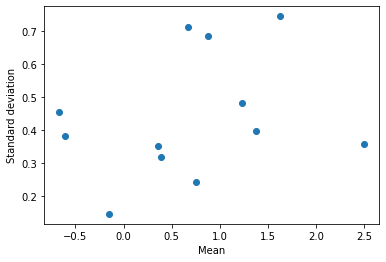

In [4]:
subject_groups = data.groupby('subject')
subj_variance = subject_groups.std()['errors'].sort_index()
subj_mean = subject_groups.mean()['errors'].sort_index()

plt.scatter(subj_mean, subj_variance)
plt.ylabel('Standard deviation')
plt.xlabel('Mean')
plt.show()

According to the article,

>There is no suggestion that there is a relationship between the variability of the differences and the magnitude of the ejection fraction.

The one-way ANOVA is shown in the table below.

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

data['subject'] = data['subject'].astype(str)
lm = ols('errors ~ subject',data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
subject,11.0,43.567049,3.960641,17.397988,3.436678e-13
Residual,48.0,10.927169,0.227649,NaN,NaN


According to the article, 
>The estimated variance of multiple between-method differences for the same subject is the mean square error, of the residual mean square.

In [6]:
var_intra = table.mean_sq['Residual']
var_intra

0.22764935515873017

## Estimate $\sigma^2_{\text{inter}}$

The variance for differences between the average **across subjects** can also be found from the ANOVA table, using the difference between the mean squares for subjects and the residual mean square.

In [7]:
var_inter = table.mean_sq['subject'] - table.mean_sq['Residual']
var_inter

3.7329914889971145

We must divide this by a value which depends on the number of observation on each subject. If the number of observations on subject $i$ is $m_i$, this divisor is 

$$\frac{\left(\sum  m_i\right)^2 - \sum m_i^2}{(n-1)\sum m_i}$$

where $n$ is the number of subjects. If all subject have the same number of observations $m$, this factor reduces to $m$.

In [8]:
num_samples = data.shape[0]
square_of_sum = num_samples ** 2
subject_count = data.groupby('subject').count()['errors']
n_subjects = subject_count.shape[0]
sum_of_squares = sum(subject_count ** 2)

print(f'Sum of squares is {sum_of_squares}.')

denominator = (square_of_sum - sum_of_squares)/((n_subjects-1) * num_samples)
denominator

Sum of squares is 314.


4.9787878787878785

In [9]:
var_inter = var_inter / denominator
var_inter

0.7497791791655799

## Calculate total variance

The total variance for single differences on different subjects is then $\sigma_{\text{inter}} + \sigma_{\text{intra}}$

In [10]:
var = var_inter + var_intra
var

0.9774285343243101

If the subject differences weren't accounted, the variance would be:

In [11]:
var_all = data['errors'].std() ** 2
var_all

0.9236308192090397

If only the mean differences were accounted, the variance would be

In [19]:
var_means = data.groupby('subject').mean()['errors'].std() ** 2
var_means

0.849725117999725

## Make Bland-Altman plot

In [14]:
stdev = np.sqrt(var)
stdev

0.9886498542579724

In [15]:
mean = data['errors'].mean()
mean

0.6021666666666667

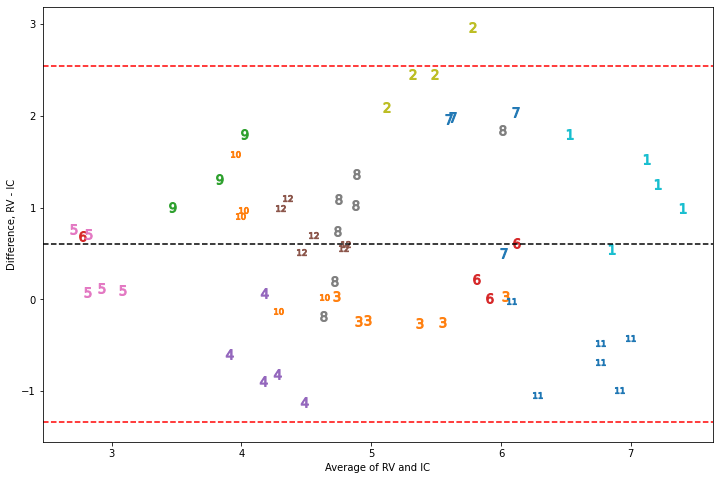

In [16]:
plt.subplots(figsize=(12, 8))
for x in set(data['subject']):
    d = data[data['subject'] == x]
    plt.scatter(d['means'], d['errors'], marker=f'${x}$', s=100)

plt.axhline(mean, linestyle='--', c='black')
plt.axhline(mean + 1.96 * stdev, linestyle='--', c='red')
plt.axhline(mean - 1.96 * stdev, linestyle='--', c='red')
plt.ylabel('Difference, RV - IC')
plt.xlabel('Average of RV and IC')
plt.show()